In [1]:
!pip install tensorflow_datasets

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def map_image_with_noise (image , label):
    noise_factor=0.5
    image = tf.cast(image , dtype =tf.float32 )
    image = image /255.0
    factor = noise_factor * tf.random.normal(shape = image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy , 0.0 , 1.0)
    return image_noisy , image
    

In [4]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [5]:
def denoising_encoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)  # Downsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)  # Downsample to (7, 7)
    
    return max_pool_2


def decoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)  # Upsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)  # Upsample to (28, 28)
    
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up_sample_2)
    return conv_3


   


In [6]:
def build_autoencoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    encoded = denoising_encoder(inputs)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs, decoded)
    return autoencoder

In [7]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
history = autoencoder.fit(train_dataset,
                          epochs=10,
                          steps_per_epoch=60000 // BATCH_SIZE,
                          validation_data=test_dataset,
                          validation_steps=10000 // BATCH_SIZE)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 58s 119ms/step - loss: 0.3673 - val_loss: 0.3038
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - loss: 0.3000 - val_loss: 0.2983
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 0.2953 - val_loss: 0.2949
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - loss: 0.2923 - val_loss: 0.2931
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - loss: 0.2906 - val_loss: 0.2916
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 68s 145ms/step - loss: 0.2891 - val_loss: 0.2910
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - loss: 0.2881 - val_loss: 0.2899
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - loss: 0.2876 - val_loss: 0.2897
Epoch 9/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - loss: 0.2870 - val_loss: 0.2889
Epoch 10/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 66s 140ms/step - loss: 0.2863 - val_loss: 0.2884


In [9]:
def display_noisy_and_denoised_images(autoencoder, dataset):
    for noisy_images, original_images in dataset.take(1):
        denoised_images = autoencoder.predict(noisy_images)
        plt.figure(figsize=(20, 4))
        for i in range(10):
            # Display original noisy images
            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(noisy_images[i].numpy().reshape(28, 28), cmap='gray')
            plt.title("Noisy")
            plt.axis("off")
            
            # Display denoised images
            ax = plt.subplot(2, 10, i + 11)
            plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
            plt.title("Denoised")
            plt.axis("off")
        plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


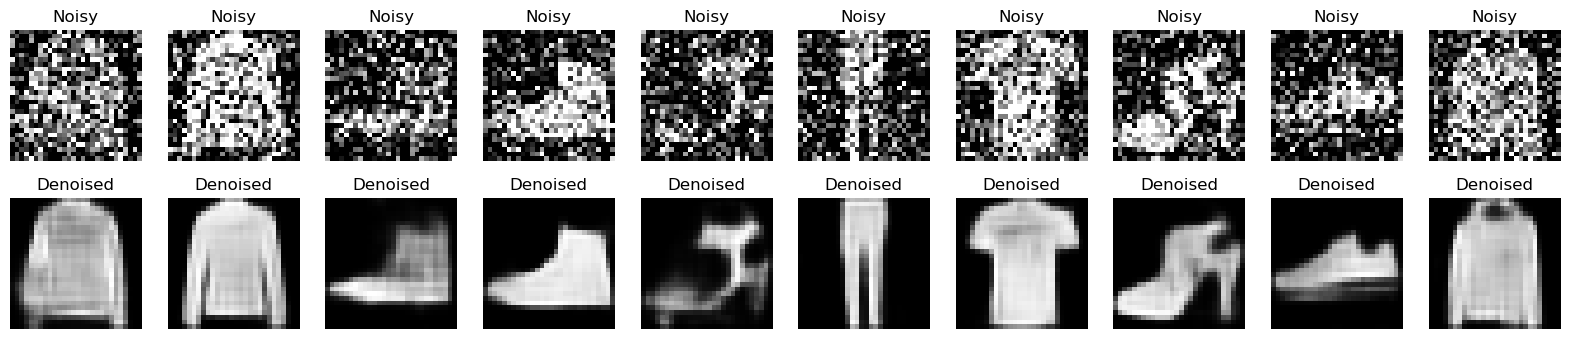

In [10]:
display_noisy_and_denoised_images(autoencoder, test_dataset)